In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from random import randint
import json

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [146]:
data = pd.read_csv('/content/drive/MyDrive/datasets/data_ds.csv')
users = pd.read_csv('/content/drive/MyDrive/datasets/users_ds.csv')
items = pd.read_csv('/content/drive/MyDrive/datasets/items_ds.csv')

In [147]:
print(data.head(),'\n', users.head())

   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596 
    user_id  age  gender  occupation zip_code
0        1   24       1  technician    85711
1        2   53       0       other    94043
2        3   23       1      writer    32067
3        4   24       1  technician    43537
4        5   33       0       other    15213


In [148]:
#encode occupation
user_enc = LabelEncoder()
users['occupation_enc'] = user_enc.fit_transform(users['occupation'].values)
zip_enc = LabelEncoder()
users['zip_code'] = zip_enc.fit_transform(users['zip_code'].values)
users = users.drop(['occupation'], axis=1)

user_vectors = []
for i in range(len(users)):
  user_vectors.append([users['age'][i], users['gender'][i],
                      users['zip_code'][i], users['occupation_enc'][i]])
users['u_vector'] = user_vectors

users.head()

,user_id,age,gender,zip_code,occupation_enc,u_vector
0,1,24,1,622,19,"[24, 1, 622, 19]"
1,2,53,0,689,13,"[53, 0, 689, 13]"
2,3,23,1,270,20,"[23, 1, 270, 20]"
3,4,24,1,331,19,"[24, 1, 331, 19]"
4,5,33,0,133,13,"[33, 0, 133, 13]"


In [149]:
def find_avr(x):
  s = 0
  num = 0
  for el in x:
    if (el != 0):
      s += el
      num += 1
  if (num == 0): return 0
  return s / num

In [150]:
def count_sim(x, y):
  if (len(x) != len(y)): return None
  x_mean = find_avr(x)
  y_mean = find_avr(y)

  sum_xy = 0
  sum_x2 = 0
  sum_y2 = 0
  for i in range(len(x)):
    if x[i] == 0: xi = x[i]
    else: xi = x[i] - x_mean
    if y[i] == 0: yi = y[i]
    else: yi = y[i] - y_mean
    sum_xy += xi*yi
    sum_x2 += xi**2
    sum_y2 += yi**2
  if (sum_x2**0.5 * sum_y2**0.5 == 0): return None
  rez = sum_xy / (sum_x2**0.5 * sum_y2**0.5)
  return rez

In [151]:
user_user_sim = np.zeros((len(users),len(users)))

In [152]:
for u1 in range(len(users)):
  for u2 in range(u1, len(users)):
    Sij = count_sim(users['u_vector'][u1], users['u_vector'][u2])
    user_user_sim[u1][u2] = Sij
    if (u1 != u2): user_user_sim[u2][u1] = Sij #Sij == Sji

In [153]:
def predict_rating_UtoU(user, item):
  sim_list = list()
  for i in range(len(users)):
    if (user-1 == i): continue
    sim = user_user_sim[user-1][i]
    if (sim < 0): continue #if user not similar
    if (coll_filt[item-1][i] == 0): continue #if item wasn't rated by user
    sim_list.append((sim, i))

  pred_rating = 0
  num = 0
  for (sim, indx) in sim_list:
    pred_rating += coll_filt[item-1][indx] * sim
    num += sim
  if (num == 0): return 0.0
  pred_rating = pred_rating / num
  return pred_rating

In [ ]:
#check, how good model can predict user's reting
#hide 5 users and try to fill it by model
#evaluation - RMSE

In [154]:
coll_filt = np.zeros((len(items),len(users)))
coll_filt_cache = np.zeros((len(items),len(users)))

for row in range(len(data)):
  item = data['item_id'][row]
  user = data['user_id'][row]
  coll_filt[item-1][user-1] = data['rating'][row]
  coll_filt_cache[item-1][user-1] = data['rating'][row]

In [155]:
k = 0
users34 = len(users) - (len(users) // 8)
for user in range(users34, users34 + 5):
  for item in range(len(items)):
    if (coll_filt[item][user-1] != 0):
      k += 1
    coll_filt[item][user-1] = 0
k

417

In [156]:
y = list()
pred_y_UtoU = list()
k = 0
for user in range(users34, users34 + 5):
  for item in range(1, len(items)+1):
    if (coll_filt_cache[item-1][user-1] != 0):
      y.append(coll_filt_cache[item-1][user-1])
      UtoU = predict_rating_UtoU(user, item)
      pred_y_UtoU.append(UtoU)
      print(k, end = ' ')
      k+=1
      if (k % 35 == 0): print('')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 
70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 
105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 
140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 
175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 
210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 
245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275

RMSE = 0.9157067802780935


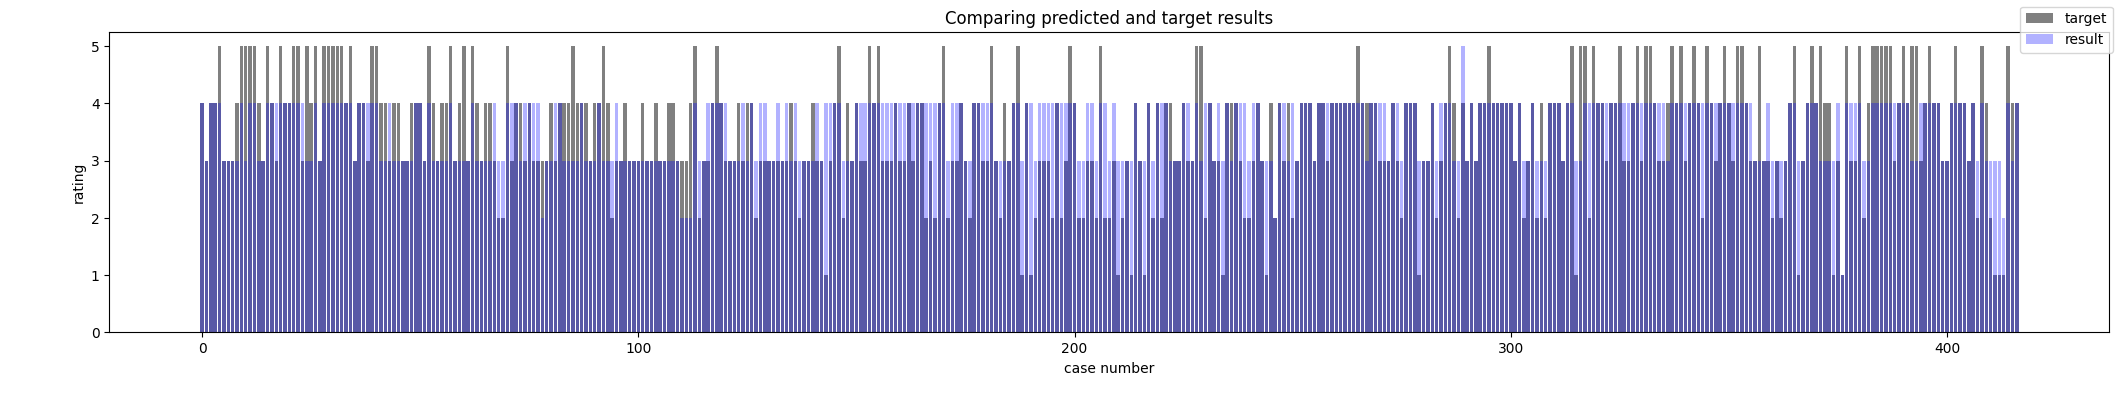

In [157]:
from sklearn.metrics import mean_squared_error

result = list()
for el in pred_y_UtoU:
  result.append(round(el))

fig = plt.figure(figsize =(20, 3))
ax = fig.add_axes([1, 1, 1, 1])
ax.bar([el for el in range(k)], y, label='target', color='gray')
ax.bar([el for el in range(k)], result, alpha=0.3, label='result', color='blue')
fig.legend()
plt.title("Comparing predicted and target results")
plt.xlabel('case number')
plt.ylabel('rating')
plt.savefig('UtoU_result.png', bbox_inches='tight')

print(f"RMSE = {mean_squared_error(y, pred_y_UtoU)**0.5}")
plt.show()